# Master Thesis Script
## Extended ABM (modelling total RT count)

In [2]:
# import all necessary packages
import numpy as np 
import pandas as pd
from transformers import pipeline
import torch
import regex as re
import transformers
import json
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import matplotlib.pyplot as plt
import scipy
import statistics
import math
import random
import statsmodels.api as sm
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import nbinom
import ast
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import itertools

2023-08-10 13:23:42.674284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 13:23:43.033408: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 13:23:44.462798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-10 13:23:44.462879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Create Agent-Based Model
- This step focuses on answering the second research question, which looks at the platform algorithm. In this script, the base model is presented, which is calibrated to observed data in terms of simulated and observed retweet count distributions. To then observe the impact of changes in the platform ranking algorithm, various tweaks can be made in the model. These are not specifically implemented here, but some code that has been commented out is included, to give an indication on how such "interventions" would be implemented.

- The network which this ABM is based upon was created from empirical data collected through the Twitter API on Congress Member follower lists. The retweeting decision of each agent is made by applying the estimated logistic regression model. In order to be able to calibrate the model to observed retweeting data, random draws from our dataset of tweets are fed into the model and matched with the tweeting politician, after which the tweet makes its way through the network of politicians. In each timestep, the tweet progresses further in the network, i.e., it if was retweeted by politician A in timestep 2, it reaches the followers of politician A in timestep 3, who then make their respective retweet decisions.

- Importantly, we have estimated a model for politicians' decisions on retweeting only. Thus, we do not know how a user of the general public decides on retweeting. However, to be able to simulate the complete retweet count, this total retweet count is derived from the number of followers a retweeting politician has, whose ideology is in alignment with the politician. This ideology has been estimated in previous steps and is based on the relative number of Democrat and Republican Congress Members a given user follows.

In [141]:
# Load the logit model from the file

with open('logitModel_20230630_NeutralDummy.pkl', 'rb') as file:
    loaded_model_NeutralDummy = pickle.load(file)

All required helper functions for the ABM are listed below.

In [142]:
def sort_lists(list1, list2):
    sorted_pairs = sorted(enumerate(zip(list2, list1)), key=lambda x: x[1][0], reverse=True)
    sorted_list1 = [pair[1][1] for pair in sorted_pairs]
    return sorted_list1

In [143]:
def make_binary_decision(probability):
    random_num = random.random()  # Generate random number between 0 and 1
    if random_num < probability:
        return True
    else:
        return False

In [144]:
def sum_squared_differences(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    squared_diff_sum = 0
    for i in range(len(list1)):
        diff = list1[i] - list2[i]
        squared_diff_sum += diff ** 2
    
    return squared_diff_sum

In [145]:
def print_bold(text):
    # ANSI escape sequence for bold text
    bold_start = "\033[1m"
    bold_end = "\033[0m"

    # Print the text in bold
    print(bold_start + text + bold_end)

In [174]:
# Complete code for agent-based model, which consists of one class

class Environment:
    
    def __init__(self, NG_df_recent, pol_network_dict, loaded_model_final, timeline_length, misinfo_downgrade, emotion_boost):
        """
        This method is executed when an instance of this class is created.
        We enable access to the input variables across all methods of this class.
        
        """
        self.NG_df_recent = NG_df_recent
        self.pol_network_dict = pol_network_dict  
        self.loaded_model_final = loaded_model_final
        self.timeline_length = timeline_length
        self.misinfo_downgrade = misinfo_downgrade
        self.emotion_boost = emotion_boost
        self.tweet_df_with_authors = pd.DataFrame()
        
        
    def setup(self):
        """
        This method sets up the initial state of the simulation by initializing the counter of timesteps with 0.
        """
        
        self.step_counter = 0
     
    
    def post_tweets(self):
        """
        This method goes through all agents in the model in each timestep, matches them with tweets posted by
        the according politician in the observed data and in line with the politician's assigned tweeting frequency, 
        lets them post a given number of tweets. Once posted, these tweets are marked as having been tweeted, in the
        total tweet dataset.
        
        """
    
        tweet_lst = []
        
        total_tweet_author_lst = []
        
        for pol_entry in self.pol_network_dict:
            
            politician = pol_entry["Politician_ID"]
            
            # reduce tweet frequency/day by a factor, to reduce the number of tweets posted per timestep
            # & ensure no politician's tweeting frequency is reduced to zero
            tweet_frequency = int(round((pol_entry["Tweet_Frequency_Day"]*0.05),0))
            if tweet_frequency == 0:
                tweet_frequency = 1
          
            # get indices of tweets posted by the politician in the iteration of this loop
            # only get indices from tweets that have not been posted yet
            row_indices = self.NG_df_recent.index[(self.NG_df_recent["author_id_new"] == politician) & (self.NG_df_recent["tweeted"] != 1)].tolist()
            num_row_indices = len(row_indices)
            if num_row_indices >= 1 and num_row_indices >= tweet_frequency: 
        
            # take random indices from the matched rows, matching the number of tweets per day by given CM
                random_tweet_indices = random.sample(row_indices, tweet_frequency)
            # Extract the matched rows to a dictionary
            elif num_row_indices >= 1 and num_row_indices < tweet_frequency:
                random_tweet_indices = row_indices
            else:
                continue
             
            # create corresponding list of posting author, to add to tweet df below
            indices_to_use = random_tweet_indices
            number_of_tweets_posted = len(indices_to_use)
            tweet_author_lst = [politician]*number_of_tweets_posted
            total_tweet_author_lst.append(tweet_author_lst)
          
            tweets = self.NG_df_recent.iloc[indices_to_use].to_dict('records')
            
            tweet_lst.extend(
                [
                    {**tweet, "timestep_posted": self.step_counter, "Simulated_retweet_count": 0}
                    for tweet in tweets
                ])
            self.NG_df_recent.loc[indices_to_use, "tweeted"] = 1
      
        self.tweet_lst = tweet_lst
       
        # make flat list from nested list total_tweet_author_lst
        total_tweet_author_lst_flat = [item for sublist in total_tweet_author_lst for item in sublist]
        
        # create dataframe of tweets for complete simulation, which saves the tweeting and all retweeting authors
        # for a given tweet
        
        tweet_id_values = []
        tweet_NG_values = []
        for tweet_dict in self.tweet_lst:
            tweet_id_values.append(tweet_dict["id"])
            tweet_NG_values.append(tweet_dict["NG_score"])
        
        tweet_ids = [d['id'] for d in self.tweet_lst]
        timestep_tweet_df_with_authors = pd.DataFrame()
        timestep_tweet_df_with_authors["Tweet_ID"] = tweet_id_values
        
        timestep_tweet_df_with_authors = timestep_tweet_df_with_authors.assign(Tweet_RT_Authors=[[value] for value in total_tweet_author_lst_flat])
        if self.step_counter == 0:
            self.tweet_df_with_authors = timestep_tweet_df_with_authors.copy()
        else:
            tweet_df_with_authors_concat = pd.concat([self.tweet_df_with_authors, timestep_tweet_df_with_authors])
            self.tweet_df_with_authors = tweet_df_with_authors_concat.copy()
        self.tweet_df_with_authors["Tweet_ID"] = self.tweet_df_with_authors["Tweet_ID"].astype(int)
        
        # add RTs according to tweeting author follower count
        # get author follower numbers from total_tweet_author_lst_flat
        pol_network_merged = pd.DataFrame(self.pol_network_dict)
        ids_df = pd.DataFrame({'Politician_ID': total_tweet_author_lst_flat})
        
        # Perform a left join between the IDs DataFrame and the original DataFrame
        merged_df = pd.merge(ids_df, pol_network_merged, on='Politician_ID', how='left')
        merged_df["id"] = tweet_ids
        merged_df = merged_df[["Politician_ID", "Follower_count", "SamePartyShare","id"]]
        merged_df["SameParty_Follower_count"] = ((merged_df["SamePartyShare"] * merged_df["Follower_count"] ))
        merged_df = merged_df[["id", "SameParty_Follower_count"]]
        
        
        if merged_df.empty:
            pass
        else:
            merged_df_new = pd.merge(self.NG_df_recent, merged_df, on='id', how='left')

        # Increase the 'Simulated_retweet_count' by the corresponding 'Follower_count_weighted' value
        # this is done to simulate the total number of retweets, being derived from the number of followers the
        # respective politician has and multiplying the number of followers by a pre-defined factor to best match
        # observed retweet distribution
        
            merged_df_new['Simulated_retweet_count'] += (0.0001*((merged_df_new["SameParty_Follower_count"]))).fillna(0)
          
              
        
            merged_df_new.drop("SameParty_Follower_count", axis=1, inplace=True)
          
            self.NG_df_recent = merged_df_new.copy()
  

        print(f"Number of Tweets posted: {len(self.tweet_lst)}")
        
          
    def add_posted_tweets(self):
        """
        This method adds the posted tweets to the feed of the posting politicians' followers
        
        """
        
        for tweet in self.tweet_lst:
            tweet["timestep_received"] = self.step_counter
            matched_dict = next((item for item in self.pol_network_dict if item['Politician_ID'] == tweet["author_id_new"]), None)
            if matched_dict:
                pol_followers = ast.literal_eval(matched_dict["politician_followers"])
                pol_followers_set = set(pol_followers)
                self.pol_network_dict = [
                    {**pol_dict, "Twitter_feed": self.add_tweet_to_feed(pol_dict, tweet)}
                    if pol_dict["Politician_ID"] in pol_followers_set
                    else pol_dict for pol_dict in self.pol_network_dict  ]
     
    def add_tweet_to_feed(self, pol_dict, tweet):
        """
        This method is a helper method for add_posted_tweets
        It adds a tweet to the user's feed if it was posted/retweeted by a user they follow,
        and if this tweet does not yet exist on their feed.        
        """
        
        if not isinstance(pol_dict["Twitter_feed"], list):
            pol_dict["Twitter_feed"] = [tweet]
        
        else: 
            pol_dict["Twitter_feed"].append(tweet)
       
        return pol_dict["Twitter_feed"]

    
                            
    def add_retweeted_tweet(self):
        """
        This method has the same logic as the above method, but adds retweets (instead of original tweets)
        to user feeds.
        
        """
        retweet_lst = self.retweet_df.to_dict('records')
       
        for tweet in retweet_lst:
            tweet["timestep_received"] = self.step_counter
        # extract list of followers of tweet author
            matched_dict = next((item for item in self.pol_network_dict if item['Politician_ID'] == tweet["Retweeting_Politician_ID"]), None)
           
            pol_followers = matched_dict["politician_followers"]
            pol_followers = ast.literal_eval(pol_followers)
            pol_followers_set = set(pol_followers)
    # now for each politician follower, in the pol_network_2 df add the tweet to their Twitter_feed column
    
        for i, pol_dict in enumerate(self.pol_network_dict):
                if pol_dict["Politician_ID"] in pol_followers_set:
            # if follower politician does not have any tweets in their timeline yet, just add the tweet
            # need to remove duplicates of tweets added to timeline in the same timestep
                    if not isinstance(pol_dict["Twitter_feed"], list):
                        self.pol_network_dict[i]["Twitter_feed"] = [tweet]
                        
                        
                    else:
                # if the timeline already has some tweets, need to ensure we don't already have the tweet in the timeline
                        tweet_ids = set(dictionary["id"] for dictionary in pol_dict["Twitter_feed"])
                        is_present = tweet["id"] in tweet_ids
                        if not is_present:
                     # if it is not already in the timeline, add it
                            
                            
                            self.pol_network_dict[i]["Twitter_feed"].append(tweet)
                            
        
        
    def apply_ranking_algorithm(self, pol_dict):
        """
        This method is responsible for the order in which tweets are ranked in each user's feed.
        This matters because the assumption is made that users have a limited capacity of viewing and thus
        deciding upon retweeting of tweets in their feeds in a given timestep.
        Therefore, after ranking, tweets beyond a certain rank are removed and will not be considered for retweeting.
        In the base version of this model, tweets are only ranked in terms of the recency of their posting time, i.e.,
        in reverse chronological order.
        
        Parameters:
        This method takes as input the dictionary of each politician, which contains information on their
        follower count, Party and current Twitter feed, among other variables.
        
        Returns:
        The method returns the ranked Twitter feed, which has been cut off after the specified maximum number 
        of tweets to be considered.
        
        """
        follower_party = pol_dict["Party"]
        tweets = pol_dict["Twitter_feed"]
        
        authors_follower_count = []
        
        if not isinstance(tweets, list):
            return None
        
        for tweet in tweets:
            authors_follower_count.append(tweet["Follower_count"])
     
       # this line only becomes relevant if tweets are scored by further criteria, e.g., misinformation score
        # and does not alter results in the base version 
        tweet_score_lst = [ 0 for tweet in tweets]
        
        ranked_tweets = tweets
        demote_lst = []
        for idx, tweet_item in enumerate(ranked_tweets):
          
            timestep_posted = tweet_item["timestep_posted"] 
            #timestep_received = tweet_item["timestep_received"]
           
            if timestep_posted < self.step_counter: 
                timesteps_demote = self.step_counter-timestep_posted
                demote_lst.append(timesteps_demote)
                ranked_tweets.insert(idx + timesteps_demote, ranked_tweets.pop(idx))
        
        ## commented code only relevant if we implement an intervention
        # misinformation downgrade
        # tweet_score_lst = [score + self.misinfo_downgrade if int(tweet["NG_score"]) <=60 else score for score, tweet in zip(tweet_score_lst, ranked_tweets)]
        # ranked_tweets_2 = sort_lists(ranked_tweets, tweet_score_lst)
        # pol_dict["Twitter_feed_ranked"] = ranked_tweets_2[:self.timeline_length]
        
        # downgrade according to level of anger expressed
        #tweet_score_lst = [score - (tweet["Anger"]* self.emotion_boost) for score, tweet, author_folls in zip(tweet_score_lst, ranked_tweets, authors_follower_count)]
        # ranked_tweets_2 = sort_lists(ranked_tweets, tweet_score_lst)
        # pol_dict["Twitter_feed_ranked"] = ranked_tweets_2[:self.timeline_length]
        
        
        pol_dict["Twitter_feed_ranked"] = ranked_tweets[:self.timeline_length]
        
        
        return pol_dict["Twitter_feed_ranked"]

    
    def retweet_decision_logit(self, pol_dict):
        """
        This method lets the respective politician decide upon retweeting, for each tweet in the ranked feed created
        with the above method.
        For the retweeting decision, the previously estimated logistic regression model is used, while a binary decision is 
        then made based on the predicted probability, introducing some randomness.
        If the given politician decides to retweet, the retweet is multiplied by using the number of estimated followers
        with the same political ideology as the politician and making a random draw from this number, using a binomial 
        distribution.
        Finally, the intersection of followers between tweeting and retweeting politician is considered here,
        this overlap increasing the final retweet count due to complex contagion (a user seeing a given post several times).
        
        Parameters:
        This method takes as input the dictionary of each politician, which contains information on their
        follower count, Party and current Twitter feed, among other variables.
        
        Returns:
        The method returns a df of the retweets made by the respective politician in that timestep.
        These retweets are then added to the follower feeds in the next timestep.
        
        """
        
        
        follower_party = pol_dict["Party"]
        ranked_feed = pol_dict["Twitter_feed_ranked"]
        
        if not isinstance(ranked_feed, list):
            return None
        
        friends = pol_dict["Friend_count"]
        foll_foll_intersect_str = pol_dict["fol_fol_intersect"]
        
        
        if self.step_counter > 0:
            key_to_drop = "Retweeted"
            key_to_drop_2 = "Read"
            value_to_drop = True

            # Drop dictionaries with the specified key value
            # as we only want to consider tweets that have not been considered for retweeting yet
            ranked_feed = [d for d in ranked_feed if d.get(key_to_drop) != value_to_drop]
            ranked_feed = [d for d in ranked_feed if d.get(key_to_drop_2) != value_to_drop]
        
        if len(ranked_feed)<1:
            return None
        ranked_feed_df = pd.DataFrame(ranked_feed)
        author_ids = ranked_feed_df["author_id_new"].tolist()
        tweet_ids = ranked_feed_df["id"].tolist()
            
        # now get sum of follower-follower intersections of current politician with all politicians who have retweeted the tweets
        foll_foll_intersect = ast.literal_eval(foll_foll_intersect_str)
          
        for item in foll_foll_intersect:
            for key, value in item.items():
                if value is None:
                    item[key] = 0
    
        tweet_df_with_authors_filtered = self.tweet_df_with_authors[self.tweet_df_with_authors["Tweet_ID"].isin(tweet_ids)]
        authors_lists = tweet_df_with_authors_filtered.groupby("Tweet_ID")["Tweet_RT_Authors"].apply(list)

        # Calculate total sums of foll-foll intersections for each matched list
        foll_foll_intersection_sum_lst = []
        for authors in authors_lists:
            intersect_sum = 0
            for author in authors:
                
                # get intersection of our current author with all authors of this tweet:
                try:
                    match = [d["intersection"] for d in foll_foll_intersect if d.get("author_id") == author][0]
                    if isinstance(match, int):
                        intersect_sum +=match
                except:
                    pass
               
            # reduce the total intersection by a factor, to reflect followers being counted multiple times (i.e.,
            # occuring across several pairwise intersections)
            foll_foll_intersection_sum_lst.append((intersect_sum*0.1))
      
        
        number_followers_generalpublic = pol_dict["Follower_count"]
        
        # add intersection per tweet from follower number
        followers_plus_intersection_per_tweet = [number_followers_generalpublic+item for item in foll_foll_intersection_sum_lst]
        
        tweet_df = pd.DataFrame(ranked_feed)
       
        # set up all necessary input variables into the logit model
        tweet_df["Same_Party_Dummy"] = 0
        tweet_df.loc[tweet_df["Party"] == follower_party, "Same_Party_Dummy"] = 1
        tweet_df['Interaction_fear_SameParty'] = tweet_df['Fear']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_happiness_SameParty'] = tweet_df['Happiness']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_sadness_SameParty'] = tweet_df['Sadness']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_SameParty_NG'] = tweet_df['NG_score']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_Outgroup_SameParty'] = tweet_df['Number_Outgroup_Words_log']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_Ingroup_SameParty'] = tweet_df['Number_Ingroup_Words_log']*tweet_df['Same_Party_Dummy']
         
                    
        # add this to the df column, which do not exist in the dataset yet   

        tweet_df["Followers_plus_foll_foll_intersection"] = followers_plus_intersection_per_tweet
        tweet_df["Follower_count"] = number_followers_generalpublic
            
        X = tweet_df[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log','Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral', 'Interaction_fear_SameParty', 'Interaction_happiness_SameParty',
                             'Interaction_sadness_SameParty', 'Interaction_SameParty_NG',                             
                             'Interaction_Outgroup_anger','Interaction_Ingroup_anger',
                             'Interaction_Outgroup_fear', 'Interaction_Outgroup_happiness',
                      'Interaction_Outgroup_SameParty', 'Interaction_Ingroup_SameParty'
                             ]]
        X.insert(0, 'Constant', 1)
 
        # use logit model from above to estimate retweeting probability of given tweet
        predicted_prob_logit = self.loaded_model_final.predict(X).values.tolist()
          
        # after trying several options, reducing the predicted probability by a factor of 0.3 fits observed results best
        predicted_prob = [item *0.3 for item in predicted_prob_logit]
       
        tweet_df["Predicted_prob"] = predicted_prob
                       
        # make binary decision based on this prediceted probability
        tweet_df["decision_RT"] = tweet_df["Predicted_prob"].apply(lambda x: make_binary_decision(x))
        # tweet has been read
        tweet_df["Read"] = True
        tweet_df_RT = tweet_df[tweet_df["decision_RT"] == True]
        # record which tweets the politician retweeted
        retweeted_tweets = tweet_df_RT["id"].values.tolist()
        for tweet_in_feed in pol_dict["Twitter_feed"]:
            # Check if the value in the selected column matches the value_to_match
            if tweet_in_feed["id"] in retweeted_tweets:
            # Update the selected key with a new value
                tweet_in_feed["Retweeted"] = True
                
        # Create mask for tweets in the feed that the politician retweeted
        mask = tweet_df["decision_RT"] == True
          
        # add retweeting author id to our overall tweet df from the beginning of this class
        
        self.tweet_df_with_authors.loc[self.tweet_df_with_authors["Tweet_ID"].isin(tweet_df.loc[mask, "id"]), "Tweet_RT_Authors"] = self.tweet_df_with_authors.loc[self.tweet_df_with_authors["Tweet_ID"].isin(tweet_df.loc[mask, "id"]), "Tweet_RT_Authors"].apply(lambda x: x + [pol_dict["Politician_ID"]])
        

        # Update NG_df RT counts
        # change 1 RT to a value that is multiplied with followers plus foll-foll intersection
        # this value needs to be further manipulated by utilising the share of partisan/same party voters in the given CM's follower network
        democrat_share = pol_dict['DemocratShare']
        republican_share = pol_dict['RepublicanShare']
        if follower_party == "Democrat":   
            tweet_df["Followers_plus_foll_foll_intersection_SameParty_count"] = democrat_share * tweet_df["Followers_plus_foll_foll_intersection"]
        else:
            tweet_df["Followers_plus_foll_foll_intersection_SameParty_count"] = republican_share * tweet_df["Followers_plus_foll_foll_intersection"]
        
        tweet_df = tweet_df[["id", "Followers_plus_foll_foll_intersection_SameParty_count", "Predicted_prob"]]
     
        merged_df_new = pd.merge(self.NG_df_recent, tweet_df, on='id', how='left')

        # Increase the 'Simulated_retweet_count' by the corresponding 'Follower_count_weighted' value
        merged_df_new["Followers_plus_foll_foll_intersection_SameParty_count"] = merged_df_new["Followers_plus_foll_foll_intersection_SameParty_count"].fillna(0)
        
        # increase variance of retweet count by making random draws from the follower count, using a binomial distribution
        def generate_random_number(row):
            return np.random.binomial(row["Followers_plus_foll_foll_intersection_SameParty_count"], 0.0002)
        

        # Create a new column with the random numbers
        merged_df_new['binomial_distr_draw'] = merged_df_new.apply(generate_random_number, axis=1)
        merged_df_new['Simulated_retweet_count'] += merged_df_new['binomial_distr_draw']
     
        # Drop the 'Followers_plus_foll_foll_intersection_SameParty_count' column from the merged dataframe
        merged_df_new.drop(['Followers_plus_foll_foll_intersection_SameParty_count','Predicted_prob'], axis=1, inplace=True)
        self.NG_df_recent = merged_df_new.copy()
        
        retweet_records_df_1 = pd.DataFrame()     
        retweet_records_df_1["id"] = tweet_df_RT["id"]
        retweet_records_df_1["timestep_posted"] = tweet_df_RT["timestep_posted"]
        retweet_records_df_1['Retweeting_Politician_ID'] = pol_dict["Politician_ID"]
           
        retweet_records = retweet_records_df_1.to_dict("records")
        
        if len(retweet_records) > 0:
            return retweet_records
        else:
            return None

            

    def step(self):
        """
        This method performs a single timestep in the model, triggering all necessary methods,
        while updating the state of the environment and printing the timestep and number of retweets
        in each timestep.
        The methods excuted in this method include posting of tweets, retweeting of tweets (if the timestep is larger than 0),
        adding posted tweets and retweets to user feeds, applying the platform ranking algorithm, letting users decide on 
        whether to retweet or not and finally, updating the tweet dataset with the retweeting records.
        
        """
        print_bold("Time Step: ")
        print(self.step_counter)
        self.post_tweets()

        self.add_posted_tweets()
        # only if we are beyond the first timestep do we also look at retweets
        if self.step_counter > 0:
            self.add_retweeted_tweet()
      
        for i, pol_dict in enumerate(self.pol_network_dict):
            item_check = self.apply_ranking_algorithm(pol_dict)
            if not isinstance(item_check, list):
                self.pol_network_dict[i]["Twitter_feed_ranked"] = None
            else:
                self.pol_network_dict[i]["Twitter_feed_ranked"] = item_check
        total_retweet_records = []
        for i, pol_dict in enumerate(self.pol_network_dict):
   
            retweet_records = self.retweet_decision_logit(pol_dict)
           
            if isinstance(retweet_records, list):
                total_retweet_records.append(retweet_records)
      
        flat_list = [item for sublist in total_retweet_records for item in sublist]
        retweet_records_df = pd.DataFrame(flat_list)
        if len(retweet_records_df) == 0:
            return
        retweet_df = pd.merge(retweet_records_df, self.NG_df_recent, on='id', how='left')
       
        self.retweet_df = retweet_df
        print("Number of RTs: ")
        print(len(self.retweet_df))
        self.step_counter += 1

    def run(self, num_steps):
        """
        This method runs the simulation for a maximum of num_steps or until all tweets have been tweeted 
        and no more retweets are posted in a timestep.

        Parameters: 
        Number of timesteps to simulate
        
        Returns: 
        The updated df of tweets that was fed into the model, along with the simulated retweet counts and a column documenting whether 
        the tweet was tweeted.
        
        
        """
        for _ in range(num_steps):
            if self.step_counter > 0:
                count = (self.NG_df_recent["tweeted"] == 0).sum()
                # if every tweet has been tweeted, then check if number of RTs are sufficiently low to stop the simulation
                if count ==0:    
                    if len(self.retweet_df) ==0:
                        
                        break
                    
                    else:
                        self.step()
                else:
                    self.step()
            else:
                self.step()

        return self.NG_df_recent

In [175]:
# load required data

pol_network_df = pd.read_csv("pol_network_merged.csv")
pol_follower_partisanship = pd.read_csv("Politicians_Followers_Estimated_Partisanship_20230710.csv")
NG_df_recent = pd.read_csv("NG_df_recent_ABM_Public.csv")

In [199]:
# politician network data
pol_network_df.head()

,Politician_ID,Follower_count,Friend_count,politician_followers,fol_friend_intersect,author_id_old,Party,nominate_dim1,author_id_updated,fol_fol_intersect,Tweet_Frequency_Day,Twitter_feed
0,586191770,3560,806.0,"[266133081, 253252536, 756285384, 24852012, 38...","[{'author_id': 29501253, 'intersection': 43}, ...",586191770,Republican,0.684,586191770,"[{'author_id': 29501253, 'intersection': 544},...",3,NaN
1,29501253,3336833,876.0,"[23593446, 15764644, 266133081, 467823431, 156...","[{'author_id': 586191770, 'intersection': 1}, ...",29501253,Democrat,-0.350,29501253,"[{'author_id': 586191770, 'intersection': 544}...",4,NaN
2,19926675,57346,891.0,"[23976316, 20467163, 518644221, 13218102, 2661...","[{'author_id': 586191770, 'intersection': 16},...",19926675,Republican,0.520,19926675,"[{'author_id': 586191770, 'intersection': 516}...",12,NaN
3,38970940,238899,664.0,"[349296252, 234014087, 128664931, 97583689, 75...","[{'author_id': 586191770, 'intersection': 1}, ...",38970940,Democrat,-0.227,38970940,"[{'author_id': 586191770, 'intersection': 152}...",5,NaN
4,23976316,23851,927.0,"[19926675, 20467163, 518644221, 13218102, 2661...","[{'author_id': 586191770, 'intersection': 26},...",23976316,Republican,0.600,23976316,"[{'author_id': 586191770, 'intersection': 299}...",6,NaN


In [194]:
# data on politician followers' estimated partisanship
pol_follower_partisanship.head()

,Politician_ID,DemocratCount,RepublicanCount,DemocratShare,RepublicanShare
0,586191770,16,1397,0.004561,0.398233
1,29501253,1003970,10466,0.323607,0.003373
2,19926675,533,19437,0.009560,0.348627
3,38970940,109260,1461,0.467837,0.006256
4,23976316,204,5382,0.008719,0.230020


In [198]:
# tweet dataset
NG_df_recent.head()

,id,author_id,created_at,referenced_tweets.retweeted.id,retweeted_user_id,text,lang,source,public_metrics.retweet_count,public_metrics.quote_count,...,Interaction_happiness_Neutral,Interaction_sadness_Neutral,Interaction_Ingroup_anger,Interaction_Outgroup_anger,Interaction_Outgroup_fear,Interaction_Outgroup_happiness,Follower_count,SamePartyShare,Simulated_retweet_count,tweeted
0,1616520819672334336,211530910,2023-01-20 19:39:31,None,None,"Yesterday, I met with the Mahoning Valley Path...",en,None,1,0,...,0.180326,0.033115,0.000000,0.0,0.0,0.0,44069.0,0.253853,0,NaN
1,1606132669745602560,211530910,2022-12-23 03:40:43,None,None,I’ve been working on this for a long time. It...,en,None,1,0,...,0.000000,0.000000,0.034952,0.0,0.0,0.0,44069.0,0.253853,0,NaN
2,1604921696988921856,211530910,2022-12-19 19:28:45,None,None,"“By curtailing our energy supply, fuel prices ...",en,None,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,44069.0,0.253853,0,NaN
3,1598699615809048576,211530910,2022-12-02 15:24:25,None,None,NEW: I joined @RepScottPeters on @BretBaier’s ...,en,None,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,44069.0,0.253853,0,NaN
4,1597985116814385152,211530910,2022-11-30 16:05:15,None,None,.@POTUS refuses to increase American energy pr...,en,None,48,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,44069.0,0.253853,0,NaN


In [176]:
pol_follower_partisanship = pol_follower_partisanship.rename(columns = {"politician_id": "Politician_ID"})
# add follower information to politician network dataset
pol_network_df_merged = pd.merge(pol_network_df, pol_follower_partisanship, on ="Politician_ID", how = "left")
# add column for variable describing share of politician's followers that have aligned political ideology
# this was estimated in a separate step
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'SamePartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'DemocratShare']
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'SamePartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'RepublicanShare']
# convert df to dict
pol_network_dict = pol_network_df_merged.to_dict(orient='records')

In [177]:
# add follower information to the tweet dataset as well
pol_network_df_merged_Foll_count = pol_network_df_merged[["Politician_ID", "Follower_count", "SamePartyShare"]]
pol_network_df_merged_Foll_count = pol_network_df_merged_Foll_count.rename(columns = {"Politician_ID": "author_id_new"})
NG_df_recent_merged = pd.merge(NG_df_recent, pol_network_df_merged_Foll_count, on="author_id_new", how="left")
NG_df_recent = NG_df_recent_merged

In [178]:
# initiate columns to be filled during simulation
NG_df_recent["Simulated_retweet_count"] = 0
NG_df_recent["tweeted"] = np.nan

In [179]:
# take a random sample from the tweet dataset, which will be an input to the model
random_seed = 43
# Take a random sample of rows from the dataframe
sample_size = 10000
NG_df_recent_sample = NG_df_recent.sample(n=sample_size)
NG_df_recent_sample.reset_index(inplace=True)

In [180]:
# set length of timeline indicating how many tweets a politician makes a retweet decision on, in each timestep
timeline_length = 20
# additional variables used if intervention is implemented
misinfo_downgrade = 50
emotion_boost = 50

In [181]:
# run the simulation
env = Environment(NG_df_recent_sample, pol_network_dict, loaded_model_NeutralDummy, timeline_length, misinfo_downgrade, emotion_boost)
env.setup()
# 120 steps are sufficient for this scenario, to post all tweets fed into the model & to have no further retweets be posted
NG_df_recent_updated = env.run(num_steps=120)

Time Step: 
0
Number of Tweets posted: 
564
Number of RTs: 
1715
Time Step: 
1
Number of Tweets posted: 
512
Number of RTs: 
150
Time Step: 
2
Number of Tweets posted: 
469
Number of RTs: 
130
Time Step: 
3
Number of Tweets posted: 
428
Number of RTs: 
110
Time Step: 
4
Number of Tweets posted: 
397
Number of RTs: 
111
Time Step: 
5
Number of Tweets posted: 
368
Number of RTs: 
96
Time Step: 
6
Number of Tweets posted: 
342
Number of RTs: 
88
Time Step: 
7
Number of Tweets posted: 
313
Number of RTs: 
119
Time Step: 
8
Number of Tweets posted: 
287
Number of RTs: 
115
Time Step: 
9
Number of Tweets posted: 
250
Number of RTs: 
115
Time Step: 
10
Number of Tweets posted: 
237
Number of RTs: 
124
Time Step: 
11
Number of Tweets posted: 
220
Number of RTs: 
105
Time Step: 
12
Number of Tweets posted: 
208
Number of RTs: 
103
Time Step: 
13
Number of Tweets posted: 
194
Number of RTs: 
87
Time Step: 
14
Number of Tweets posted: 
180
Number of RTs: 
86
Time Step: 
15
Number of Tweets posted

In [182]:
# create lists of log number of retweets for observed and simulated data, among tweets that got tweeted in the simulation
observed_tweets = NG_df_recent_updated.loc[NG_df_recent_updated["tweeted"] == 1, "public_metrics.retweet_count"].values
observed_tweets_log = [np.log(item + 1) for item in observed_tweets]
sim_tweets = NG_df_recent_updated.loc[NG_df_recent_updated["tweeted"] == 1, "Simulated_retweet_count"].values
sim_tweets_log = [np.log(item + 1) for item in sim_tweets]

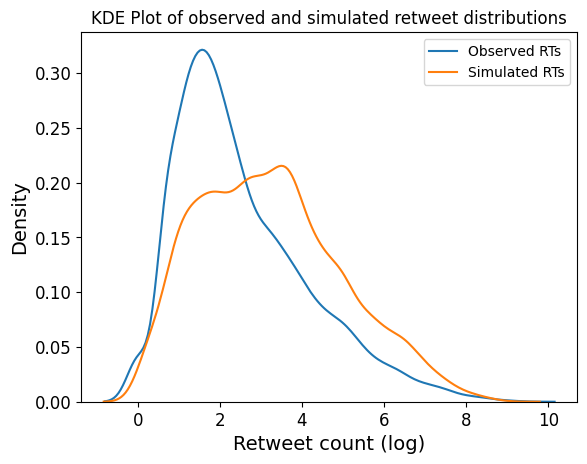

In [183]:
# Plot kernel density curve for comparison of simulation vs reality

sns.kdeplot(observed_tweets_log, label='Observed RTs')
sns.kdeplot(sim_tweets_log, label='Simulated RTs')

plt.xlabel('Retweet count (log)', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("KDE Plot of observed and simulated retweet distributions")
plt.legend()

plt.show()

The KDE plot shows that the log count of simulated and observed retweets are similar in terms of minimum and maximum values and overall dynamics. However, it can be observed that the simulation is somewhat less skewed and produces more tweets with a relatively higher retweet count, while failing to simulate exceedingly large retweet counts. This is likely due to the model not including the general public as decision makers, only assigning a passive role to them.

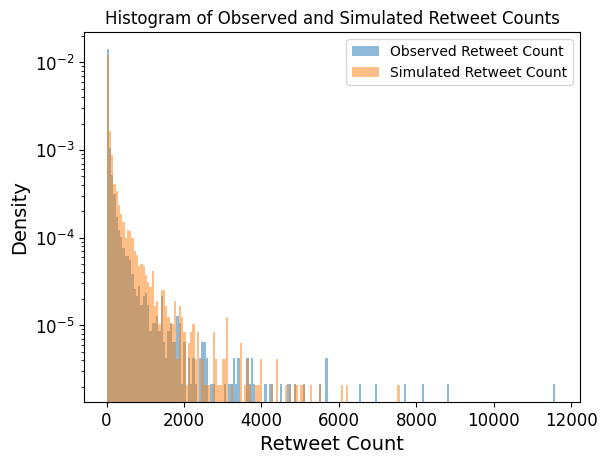

In [184]:
# Plot histogram of both distributions, with log y-axis to better observe tail of distributions

# Combine the observed and simulated data into a single list
all_tweets = observed_tweets + sim_tweets

# Calculate the common bin edges
num_bins = 200
bin_edges = np.linspace(min(all_tweets), max(all_tweets), num_bins + 1)

# Plot the histograms with the common bin edges
plt.hist(observed_tweets, bins=bin_edges, density=True, alpha=0.5, label="Observed Retweet Count")
plt.hist(sim_tweets, bins=bin_edges, density=True, alpha=0.5, label="Simulated Retweet Count")

plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

plt.xlabel("Retweet Count", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Histogram of Observed and Simulated Retweet Counts")

plt.show()

The above histogram compares the distribution of retweet counts across simulation and empirical data, with a log-transformed y-axis to better view the tail of the distribution, i.e., visualise how the model performs for the small number of tweets that go "viral". We see that the model performs relatively well until a retweet count of approximately 4,000, thereafter struggling to simulate larger retweet counts.

In [185]:
# Compare closeness of simulation to observed data using the sum of squared differences across log of retweet counts
result = sum_squared_differences(observed_tweets_log, sim_tweets_log)
print(f"The standardized SSD is: {round(result/len(sim_tweets_log),2)}")

The standardized SSD is: 4.23


The below bar chart gives insight on the average number of retweets per tweet in the simulation, divided into 5 equal sized ranges of the tweet's accompanying NewsGuard score. This chart can later be used to compare intervention effectiveness.

In [186]:
# only consider tweets that were tweeted in the simulation
NG_df_results = NG_df_recent_updated[NG_df_recent_updated["tweeted"] == 1].copy()

In [187]:
# Create NewsGuard score bins based on NG_score using custom bin edges
bin_edges = [0, 20, 40, 60, 80, 100]
NG_df_results.loc[:,'NG_score_bins'] = pd.cut(NG_df_results.loc[:,'NG_score'], bins=bin_edges)
NG_grouped_sim = NG_df_results.groupby('NG_score_bins', as_index=False)['Simulated_retweet_count'].mean()

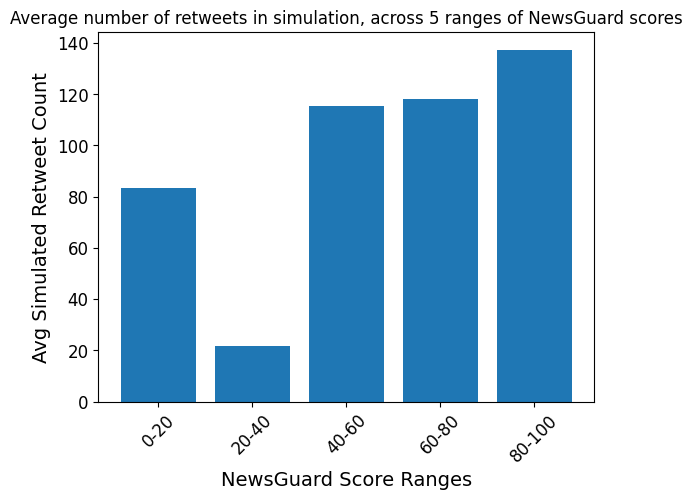

In [188]:
# Define labels for x-axis
x_labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

plt.bar(range(len(NG_grouped_sim)), NG_grouped_sim["Simulated_retweet_count"])
plt.xticks(range(len(NG_grouped_sim)), x_labels, fontsize=12, rotation=45)
plt.xlabel('NewsGuard Score Ranges', fontsize=14)
plt.ylabel('Avg Simulated Retweet Count', fontsize=14)
plt.yticks(fontsize=12)
plt.title("Average number of retweets in simulation, across 5 ranges of NewsGuard scores")
plt.show()